In [1]:
!pip install xgboost seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.7 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

Matplotlib is building the font cache; this may take a moment.


In [3]:
#Synthetic data generation
def generate_synthetic_transactions(n_skus=10, n_stores=3, start_date="2023-01-01", end_date="2024-12-31", seed=42):
    """
    Generate transactional daily-level synthetic sales data for multiple SKUs and stores.
    Returns a DataFrame with columns: date, sku, store, sales_qty, price, promo (0/1)
    """
    rng = np.random.RandomState(seed)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    rows = []
    for sku in [f"SKU_{i+1}" for i in range(n_skus)]:
        base_sales = rng.randint(5, 80)  # base daily demand for SKU
        seasonality = rng.uniform(0.8, 1.3)  # SKU-level seasonality multiplier
        for store in [f"Store_{j+1}" for j in range(n_stores)]:
            price_base = round(rng.uniform(50, 500), 2)
            trend = rng.uniform(0.0005, 0.002)  # slight upward trend
            for d, date in enumerate(dates):
                # weekly seasonality: weekends slightly higher or lower
                weekday = date.weekday()
                wk_multiplier = 1.2 if weekday >=5 else 1.0
                # yearly seasonality (sine wave)
                day_of_year = date.timetuple().tm_yday
                yearly = 1 + 0.2*np.sin(2*np.pi*day_of_year/365.25)
                # promotions randomly
                promo = 1 if rng.rand() < 0.05 else 0
                promo_boost = 1.5 if promo else 1.0
                noise = rng.normal(0, base_sales*0.15)
                sales = max(0, (base_sales * seasonality * wk_multiplier * yearly * promo_boost * (1 + trend*d) + noise))
                # occasional spikes for big marketing or season
                if rng.rand() < 0.002:
                    sales *= rng.uniform(1.8, 3.0)
                price = max(1.0, price_base * (1 + rng.normal(0, 0.01)))
                rows.append([date, sku, store, int(round(sales)), round(price,2), promo])
    df = pd.DataFrame(rows, columns=['date','sku','store','sales_qty','price','promo'])
    return df

transactions_df = generate_synthetic_transactions(n_skus=12, n_stores=4, start_date="2023-01-01", end_date="2024-10-31", seed=2025)
print("Synthetic transactions sample:")
display(transactions_df.head())

Synthetic transactions sample:


,date,sku,store,sales_qty,price,promo
0,2023-01-01,SKU_1,Store_1,83,204.40,0
1,2023-01-02,SKU_1,Store_1,68,205.46,0
2,2023-01-03,SKU_1,Store_1,49,204.57,0
3,2023-01-04,SKU_1,Store_1,68,204.01,0
4,2023-01-05,SKU_1,Store_1,80,200.68,0


In [17]:
#Aggregate to weekly level
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

transactions_df['week_start'] = transactions_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly = (transactions_df
          .groupby(['sku','store','week_start'], as_index=False)
          .agg({'sales_qty':'sum','price':'mean','promo':'max'}))
weekly = weekly.sort_values(['sku','store','week_start']).reset_index(drop=True)
print("\nWeekly aggregated sample:")
display(weekly.head())


Weekly aggregated sample:


,sku,store,week_start,sales_qty,price,promo
0,SKU_1,Store_1,2022-12-26,83,204.400000,0
1,SKU_1,Store_1,2023-01-02,482,203.612857,0
2,SKU_1,Store_1,2023-01-09,543,202.695714,0
3,SKU_1,Store_1,2023-01-16,534,203.892857,1
4,SKU_1,Store_1,2023-01-23,620,203.671429,1


In [18]:

#Feature engineering: lags and rolling means
def make_time_features(df):
    df = df.copy()
    df['week'] = df['week_start']
    df['weekofyear'] = df['week'].dt.isocalendar().week.astype(int)
    df['month'] = df['week'].dt.month
    df['year'] = df['week'].dt.year
    return df

def add_lags_rolls(df, lags=[1,2,3,4], roll_windows=[4,8]):
    df = df.sort_values(['sku','store','week'])
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(['sku','store'])['sales_qty'].shift(lag)
    for w in roll_windows:
        
        df[f'roll_mean_{w}'] = df.groupby(['sku','store'])['sales_qty'].shift(1).rolling(window=w, min_periods=1).mean()
 
    df['promo_last_week'] = df.groupby(['sku','store'])['promo'].shift(1).fillna(0)
    df['price_change_1'] = df['price'] - df.groupby(['sku','store'])['price'].shift(1)
    return df

weekly = make_time_features(weekly)
weekly = add_lags_rolls(weekly, lags=[1,2,4], roll_windows=[4,8])


feature_cols = ['price','promo','lag_1','lag_2','lag_4','roll_mean_4','roll_mean_8','promo_last_week','price_change_1','weekofyear','month']
weekly_clean = weekly.dropna(subset=['lag_1','lag_2','lag_4']).reset_index(drop=True)
print("\nFeature-engineered weekly sample:")
display(weekly_clean.head())


Feature-engineered weekly sample:


,sku,store,week_start,sales_qty,price,promo,week,weekofyear,month,year,lag_1,lag_2,lag_4,roll_mean_4,roll_mean_8,promo_last_week,price_change_1
0,SKU_1,Store_1,2023-01-23,620,203.671429,1,2023-01-23,4,1,2023,534.0,543.0,83.0,410.50,410.500000,1.0,-0.221429
1,SKU_1,Store_1,2023-01-30,545,204.354286,0,2023-01-30,5,1,2023,620.0,534.0,482.0,544.75,452.400000,1.0,0.682857
2,SKU_1,Store_1,2023-02-06,592,204.495714,0,2023-02-06,6,2,2023,545.0,620.0,543.0,560.50,467.833333,0.0,0.141429
3,SKU_1,Store_1,2023-02-13,642,203.635714,0,2023-02-13,7,2,2023,592.0,545.0,534.0,572.75,485.571429,0.0,-0.860000
4,SKU_1,Store_1,2023-02-20,612,204.121429,0,2023-02-20,8,2,2023,642.0,592.0,620.0,599.75,505.125000,0.0,0.485714


In [19]:
#Train/validation split (time-based)
last_date = weekly_clean['week'].max()
val_start = last_date - pd.Timedelta(weeks=8)

train = weekly_clean[weekly_clean['week'] <= val_start].copy()
val   = weekly_clean[weekly_clean['week'] > val_start].copy()

X_train = train[feature_cols]
y_train = train['sales_qty']
X_val = val[feature_cols]
y_val = val['sales_qty']

print(f"\nTrain rows: {len(train)}, Validation rows: {len(val)}")


Train rows: 4080, Validation rows: 384


In [20]:
#Baseline: naive last-week predictor & metrics helper
def calc_metrics(y_true, y_pred):
   
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse) 
    mae = mean_absolute_error(y_true, y_pred)
    
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(1, y_true))) * 100
    return {'RMSE':rmse, 'MAE':mae, 'MAPE%':mape}


y_pred_naive = val['lag_1'].values
print("\nBaseline (last-week) metrics:", calc_metrics(y_val.values, y_pred_naive))


Baseline (last-week) metrics: {'RMSE': np.float64(91.3310712919395), 'MAE': 50.5625, 'MAPE%': np.float64(15.682672033034983)}


In [21]:
#Train XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'eta':0.08,
    'max_depth':6,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'seed':42,
    'verbosity':0
}

evallist = [(dtrain,'train'), (dval,'eval')]
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=30, verbose_eval=50)

[0]	train-rmse:263.91764	eval-rmse:254.29591
[50]	train-rmse:23.55515	eval-rmse:84.86201
[67]	train-rmse:21.26942	eval-rmse:85.72391


In [22]:
#Predict & evaluate
y_pred_xgb = bst.predict(dval)
metrics_xgb = calc_metrics(y_val.values, y_pred_xgb)
print("\nXGBoost metrics:", metrics_xgb)


print("\nComparison baseline vs XGBoost:")
print("Baseline:", calc_metrics(y_val.values, y_pred_naive))
print("XGBoost:", metrics_xgb)


XGBoost metrics: {'RMSE': np.float64(85.72390786067939), 'MAE': 42.35720443725586, 'MAPE%': np.float64(13.875209338486036)}

Comparison baseline vs XGBoost:
Baseline: {'RMSE': np.float64(91.3310712919395), 'MAE': 50.5625, 'MAPE%': np.float64(15.682672033034983)}
XGBoost: {'RMSE': np.float64(85.72390786067939), 'MAE': 42.35720443725586, 'MAPE%': np.float64(13.875209338486036)}


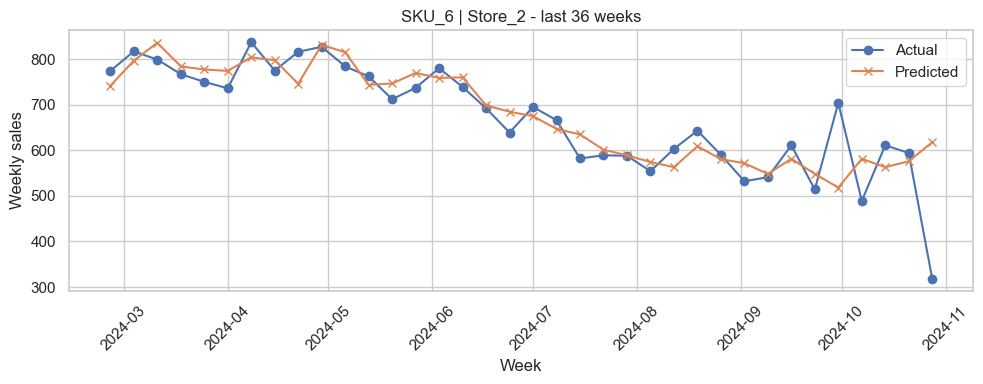

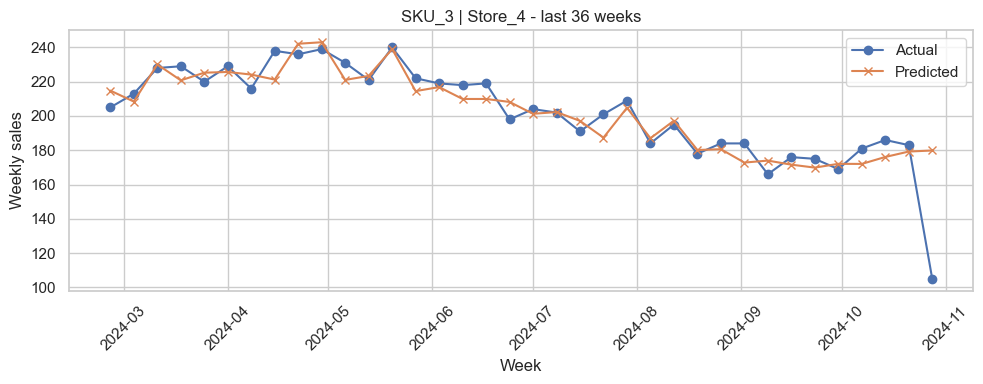

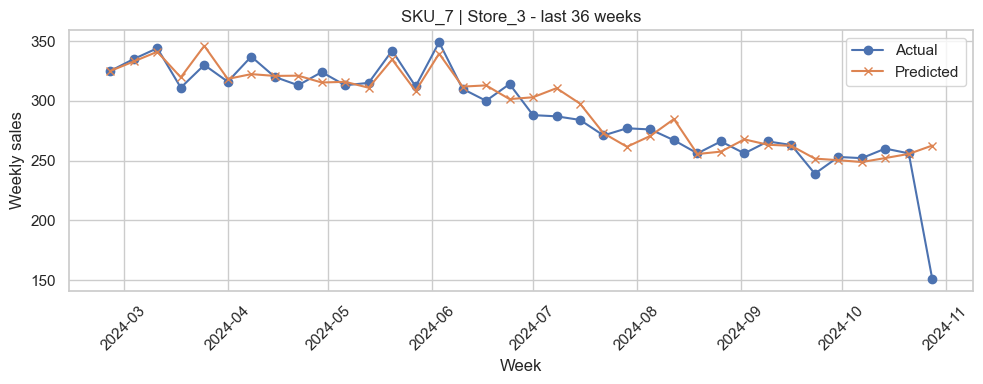

In [23]:
#Plot actual vs predicted for a few SKU-store combos
def plot_predictions_for(sku, store, weeks=24):
    subset = weekly_clean[(weekly_clean['sku']==sku)&(weekly_clean['store']==store)].sort_values('week')
    sub = subset.tail(weeks).copy()
    sub_X = sub[feature_cols]
    sub_y = sub['sales_qty']
    sub_pred = bst.predict(xgb.DMatrix(sub_X))
    plt.figure(figsize=(10,4))
    plt.plot(sub['week'], sub_y, label='Actual', marker='o')
    plt.plot(sub['week'], sub_pred, label='Predicted', marker='x')
    plt.title(f"{sku} | {store} - last {weeks} weeks")
    plt.ylabel("Weekly sales")
    plt.xlabel("Week")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

unique_pairs = weekly_clean[['sku','store']].drop_duplicates().sample(3, random_state=1).values.tolist()
for sku, store in unique_pairs:
    plot_predictions_for(sku, store, weeks=36)

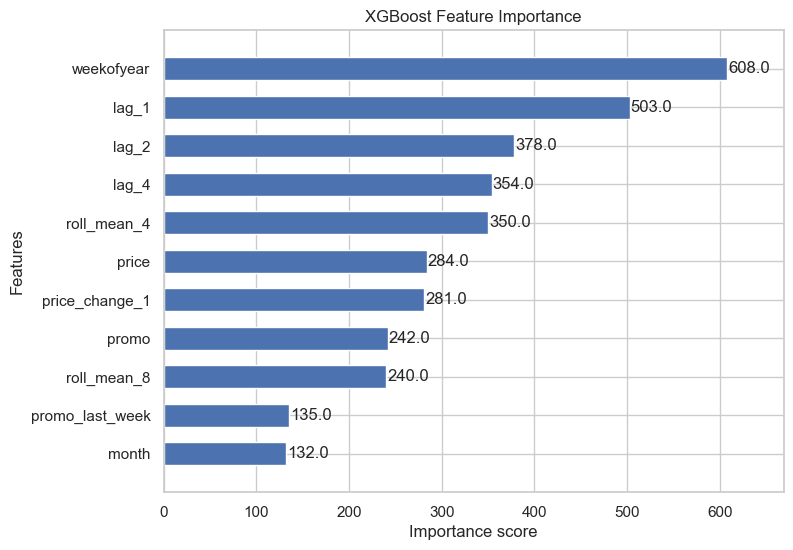

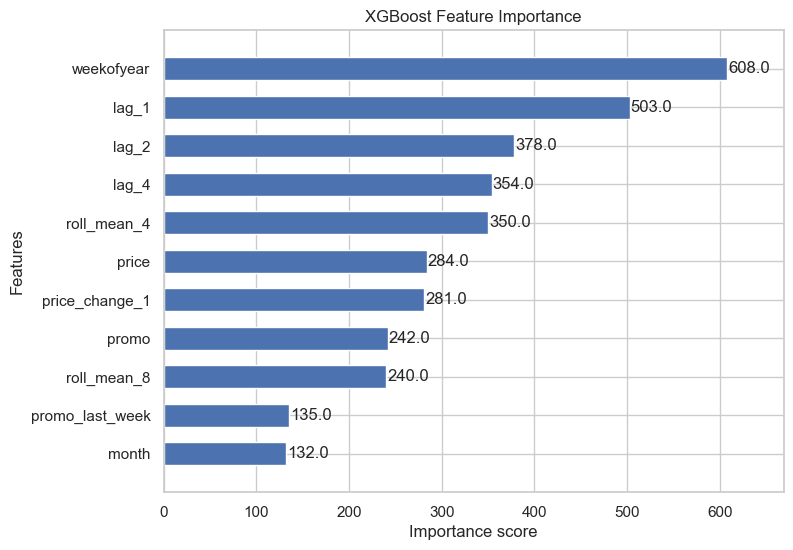

In [25]:
#first plot
fig, ax = plt.subplots(1,1, figsize=(8,6))  # Uncommented this line to define fig and ax
xgb.plot_importance(bst, max_num_features=12, height=0.6, ax=ax)
plt.title("XGBoost Feature Importance")
plt.show()

#second plot
fig, ax = plt.subplots(1,1, figsize=(8,6))
xgb.plot_importance(bst, max_num_features=12, height=0.6, ax=ax)
plt.title("XGBoost Feature Importance")
plt.show()

In [26]:
print("\nNotebook finished. You can save the model using bst.save_model('xgb_retail_sales.model').")


Notebook finished. You can save the model using bst.save_model('xgb_retail_sales.model').
